# Neural Style Transfer

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from torchinfo import summary

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## 1 - Loading Images

Import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style. However, pretrained networks from the Caffe library are trained with 0 to 255 tensor images.

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])     # transform it into a torch tensor

In [4]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
style_img = image_loader("images/picasso.jpg")
content_img = image_loader("images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a copy of it to PIL format and displaying the copy using `plt.imshow`. We will try displaying the content and style images to ensure they were imported correctly.

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()

In [7]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

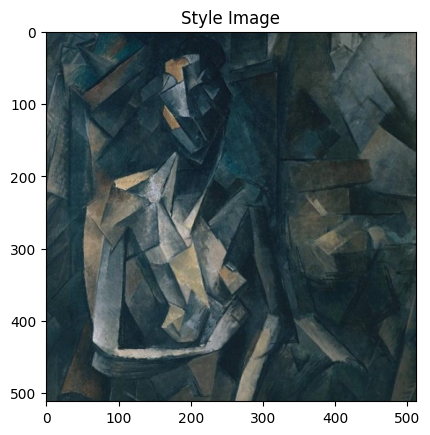

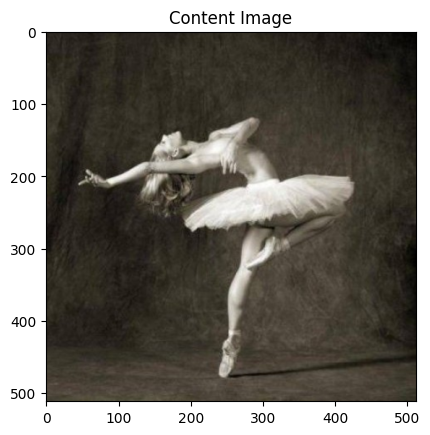

In [8]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 2 - Loss Functions

Build the Neural Style Transfer (NST) algorithm in three steps:

- First, build the content cost function $J_{content}(C,G)$
- Second, build the style cost function $J_{style}(S,G)$
- Finally, put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

<hr>

### 2.1 - Content Cost Function $J_{content}(C,G)$
One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when we do need to carry out a similar operation later for computing the style cost $J_{style}$.

**PYTHONIC IMPLEMENTATION**

```python
def content_cost(content_output, generated_output):
    """Computes the weighted content distance between the content image and the generated image.
    Arguments:
    content_output   -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image C
    generated_output -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar value representing the distance.
    """
    
    # Assume the input tensors are in the format (N, C, H, W) for PyTorch
    a_C = content_output
    a_G = generated_output
    
    # Compute the content cost
    _, C, H, W = a_G.size()
    J_content = 1 / (4 * C * H * W) * torch.sum((a_C - a_G) ** 2)
    
    return J_content
```

In [25]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # Ensure the target is detached to prevent gradients from being computed for it
        self.target = target.detach()

    def forward(self, input):
        # Use PyTorch's built-in MSE loss for efficiency and simplicity
        self.loss = F.mse_loss(input, self.target)
        return input

### 2.2 - Style Cost Function

#### 2.2.1 - Gram matrix
* The style matrix is also called a "Gram matrix."
* A gram matrix is the result of multiplying a given matrix by its transposed matrix.
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j}) }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, we would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### 2.2.2 - Compute Gram matrix $G_{gram}$
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose.

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image.

**SIMPLE IMPLEMENTATION**

```python
def gram_matrix(A):
    """
    A -- tensor of shape (C, H*W)
    GA -- Gram matrix of A, of shape (C, C)
    """
    GA = torch.mm(A, A.t())
    return GA
```

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b = number of feature maps
    # (c,d) = dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G.
* For now, we will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

**PYTHONIC IMPLEMENTATION**
```python
def compute_layer_style_cost(a_S, a_G):
    """
    a_S -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image G
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # PyTorch uses (N, C, H, W) so we don't need to transpose tensors as in TensorFlow
    _, C, H, W = a_G.size()
    
    # Reshape the tensors from (1, C, H, W) to (C, H*W) for PyTorch
    a_S = a_S.view(C, H * W)
    a_G = a_G.view(C, H * W)

    # Computing gram matrices for both images S and G using the previously defined PyTorch function
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = 1 / (4 * (C ** 2) * ((H * W) ** 2)) * torch.sum((GS - GG) ** 2)
        
    return J_style_layer
```

In [26]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 3 - Importing the Model

Import a pretrained neural network such as `VGG-19`.

> PyTorch's implementation of VGG is a module divided into two child `Sequential` modules: `features` (containing convolution and pooling layers), and `classifier` (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using `.eval()`.

In [14]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a `nn.Sequential`

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

### 3.1 - Style Weights

* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

```python
style_layers = {
    0: ('block1_conv1', 0.2),  # This is the first conv layer
    5: ('block2_conv1', 0.2),  # First layer of the second block
    10: ('block3_conv1', 0.2), # First layer of the third block
    19: ('block4_conv1', 0.2), # First layer of the fourth block
    28: ('block5_conv1', 0.2), # First layer of the fifth block
}
```

We can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

```python
def compute_style_cost(style_image_output, generated_image_output, style_layers_weights):
    """Computes the overall style cost from several chosen layers in PyTorch.
    style_image_output -- list of PyTorch tensors, the outputs from the chosen layers of the VGG19 for the style image
    generated_image_output -- list of PyTorch tensors, the outputs from the chosen layers of the VGG19 
                                for the generated image
    style_layers_weights -- list of tuples, each containing the layer index and its corresponding weight in the 
                            style cost computation

    Returns: 
    J_style -- PyTorch tensor, scalar value representing the overall style cost
    """
    
    # Initialize the overall style cost
    J_style = 0
    
    for ((layer_name, weight), a_S, a_G) in zip(style_layers_weights, style_image_output, generated_image_output):
        # Compute style cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[0], a_G[0])

        # Add weighted J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer

    return J_style
```

### 3.2 - Defining the Total Cost to Optimize

Finally, we will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

```python
def total_cost(J_content, J_style, alpha=10, beta=40):
    """Computes the total cost function in PyTorch.    
    J_content -- content cost computed above
    J_style -- style cost computed above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    return J
```

A `Sequential` module contains an ordered list of child modules. For instance, `vgg19.features` contains a sequence (`Conv2d`, `ReLU`, `MaxPool2d`, `Conv2d`, `ReLU`...) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new `Sequential` module that has content loss and style loss modules correctly inserted.

In [16]:
# desired depth layers to compute style/content losses:

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [17]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that `cnn` is a `nn.Sequential`, so we make a new `nn.Sequential`
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

Next, we select the input image. We can also use a copy of the content image or white noise.

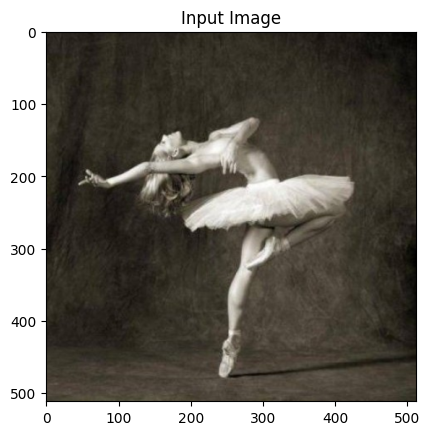

In [28]:
input_img = content_img.clone()

# # if you want to use white noise by using the following code:
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## 4 - Gradient Descent
Unlike training a network, we want to train the input image in order to minimize the content/style losses. We will create a PyTorch L-BFGS optimizer `optim.LBFGS` and pass our image to it as the tensor to optimize.

In [19]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

## 5 - Solving the Optimization Problem

Put everything together to implement Neural Style Transfer!

Here's what our program will be able to do:

<ol>
    <li>Load the content image</li>
    <li>Load the style image</li>
    <li>Randomly initialize the image to be generated
        <ul>
            <li>Either random white noise</li>
            <li>Or the content image (recommended)</li>
        </ul>
    </li>
    <li>Load the VGG19 model</li>
    <li>Compute the content cost</li>
    <li>Compute the style cost</li>
    <li>Compute the total cost</li>
    <li>Define the optimizer and learning rate</li>
</ol>

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the `backward` methods of each loss module to dynamically compute their gradients. The optimizer requires a "closure" function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [20]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    
    """Run the style transfer."""
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                                                                     style_img, content_img)

    # Optimize the input and not the model parameters; update all the requires_grad fields accordingly
    input_img.requires_grad_(True)

    # Model in evaluation mode
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.107305 Content Loss: 4.155454

run [100]:
Style Loss : 1.162711 Content Loss: 3.014017

run [150]:
Style Loss : 0.724717 Content Loss: 2.652943

run [200]:
Style Loss : 0.482494 Content Loss: 2.490521

run [250]:
Style Loss : 0.348467 Content Loss: 2.406176

run [300]:
Style Loss : 0.271888 Content Loss: 2.353855



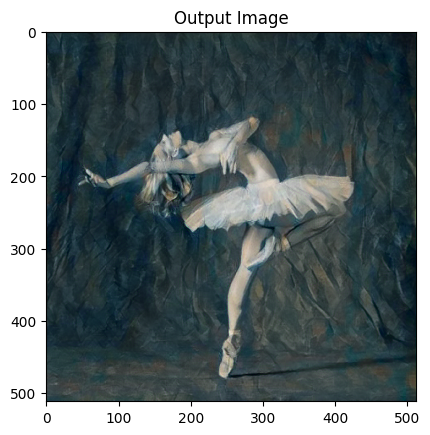

In [29]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

## 6 - Inference

In [40]:
desired_size1 = 512

loader1 = transforms.Compose([
    transforms.Resize((desired_size1, desired_size1)), # Resize the image to the specified size
    transforms.ToTensor(), # Convert the image to a tensor
])

def image_loader1(image_name):
    image = Image.open(image_name)
    # Apply transformations and fake batch dimension
    image = loader1(image).unsqueeze(0)
    return image.to(device, torch.float)

In [48]:
content_img1 = image_loader1("images/louvre_small.jpg")
style_img1 = image_loader1("images/great_wave_of_kanagawa_by_katsushika_hokusai.png")

assert style_img1.size() == content_img1.size(), \
    "we need to import style and content images of the same size"

In [49]:
print(style_img1.size())
print(content_img1.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


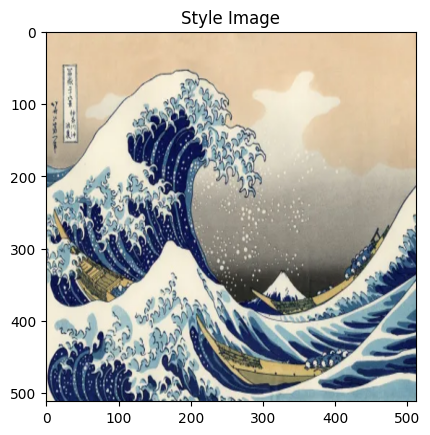

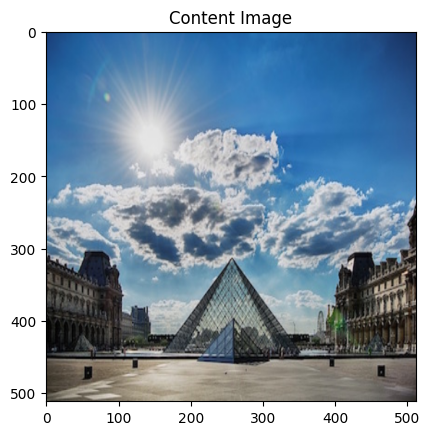

In [50]:
plt.figure()
imshow(style_img1, title='Style Image')

plt.figure()
imshow(content_img1, title='Content Image')

In [51]:
input_img1 = content_img1.clone()

In [52]:
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img1, style_img1, input_img1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 220.732513 Content Loss: 25.256197

run [100]:
Style Loss : 83.809708 Content Loss: 24.361599

run [150]:
Style Loss : 50.470798 Content Loss: 23.114452

run [200]:
Style Loss : 32.642963 Content Loss: 21.425213

run [250]:
Style Loss : 19.468430 Content Loss: 19.892298

run [300]:
Style Loss : 10.749141 Content Loss: 18.149918



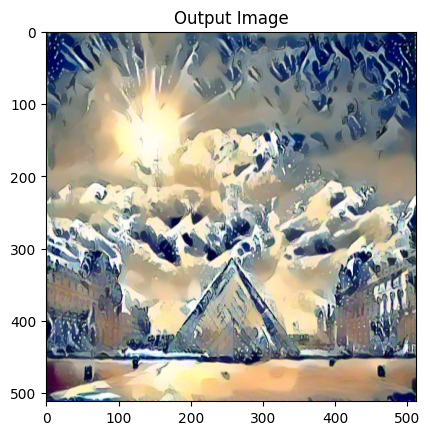

In [53]:
plt.figure()
imshow(output1, title='Output Image')
plt.ioff()
plt.show()